[![deep-learning-notes](https://github.com/semilleroCV/deep-learning-notes/raw/main/assets/banner-notebook.png)](https://github.com/semilleroCV/deep-learning-notes)

In [29]:
#@title **import required libraries**.
import torch # '2.2.1'
import torch.nn as nn # '2.2.1'

They found it beneficial to linearly project the queries, keys and values h (`num_heads`) times with different, learned linear projections to d_k, d_k and d_v dimensions, respectively. On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding d_v-dimensional output values. These are concatenated and once again projected, resulting in the final values, as depicted in the figure.

<div align="center"> <image src="https://production-media.paperswithcode.com/methods/multi-head-attention_l1A3G7a.png" width=300>  </div>

**Scaled Dot-Product Attention**: The input consists of queries and keys of dimension d_k, and values of dimension d_v. We compute the dot products of the query with all keys, divide each by √d_k, and apply a softmax function to obtain the weights on the values. In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix Q. The keys and values are also packed together into matrices K and V . We compute the matrix of outputs as (here d_ff = 2, d_k = d_v = 3):

<div align="center"> <image src="https://imgs.search.brave.com/dHTFbBXXRV02VLakl4dCaSGIrFAx8S23WyABfuPxBdc/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9qYWxh/bW1hci5naXRodWIu/aW8vaW1hZ2VzL3Qv/c2VsZi1hdHRlbnRp/b24tbWF0cml4LWNh/bGN1bGF0aW9uLTIu/cG5n" width=500>  </div>

Where do Q, K and V come from? Simply, it is to take the matrix of the sentence X and project it linearly with W_q, W_k and W_v (here d_model =4, d_ff = 2, d_k = d_v = 3).

<div align="center"> <image src="https://imgs.search.brave.com/qghth1IekFyJ3FBI1f9eWCzJZG1DDoSitUddg13jIYM/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9qYWxh/bW1hci5naXRodWIu/aW8vaW1hZ2VzL3Qv/c2VsZi1hdHRlbnRp/b24tbWF0cml4LWNh/bGN1bGF0aW9uLnBu/Zw" width=300>  </div>

At the end, all the z matrices (one for each head) are concatenated and multiplied by W_o of dimensions h*d_v rows and d_model columns, to obtain the output which will have the same dimensions as the input (here h=8).

<div align="center"> <image src="https://jalammar.github.io/images/t/transformer_attention_heads_weight_matrix_o.png" width=500>  </div>

See https://jalammar.github.io/illustrated-transformer/ for a more detailed explanation.

In [30]:
class MultiHeadAttention(nn.Module):
  """Some Information about MultiHeadAttention"""
  def __init__(self, d_model:int = 512, num_heads:int = 8):
    super(MultiHeadAttention, self).__init__()
    
    self.num_heads = num_heads

    # We make sure that the division is integer.
    assert d_model % num_heads == 0, "Size not compatible with number of heads"

    self.d_v = d_model//num_heads
    self.d_k = self.d_v

    # In order not to have to make h matrices we will "extend" them from d_k to d_model
    # that is, d_k, h times.
    self.W_q = nn.Linear(d_model, self.d_k * num_heads)
    self.W_k = nn.Linear(d_model, self.d_k * num_heads)
    self.W_v = nn.Linear(d_model, self.d_k * num_heads)

    # As we extend the arrays, we do not have to concatenate.
    self.W_o = nn.Linear(self.d_v * num_heads, d_model)

  def forward(self, Q, K, V, mask = None):

    batch_size = Q.size(0)

    """ 
      Q, K and V -> [batch_size, seq_len, d_k * num_heads]
      after transpose Q, K and V -> [batch_size, num_heads, seq_len, d_k]
    """

    Q, K, V = self.W_q(Q), self.W_k(K), self.W_v(V)
    Q = self.W_q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)  # here we are "deconcatenating" the Querys for each head.
    K = self.W_k(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
    V = self.W_v(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

    weighted_values, attention = self.scaled_dot_pruduct_attention(Q, K, V, mask)

    # contiguous() will rearrange the memory allocation so that the tensor is C contiguous https://stackoverflow.com/questions/48915810/what-does-contiguous-do-in-pytorch
    weighted_values = weighted_values.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads*self.d_k) # shape: [batch_size, seq_len, d_k * num_heads]
    return self.W_o(weighted_values), attention
  
  def scaled_dot_pruduct_attention(self, Q, K, V, mask = None):
      
      # matmul opera por cada head
      compatibility = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.as_tensor(self.d_k)) # the transpose here is, as in the paper, so that the multiplication between matrices can be done

      if mask:
         compatibility = compatibility.masked_fill(mask == 0, -float('inf'))

      attention = nn.Softmax(dim=-1)(compatibility) # dim=-1 is to be applied for each vector of q, k and v
      weighted_values = torch.matmul(attention, V)
      return weighted_values, attention

### example with random embeddings

dimensions

In [31]:
d_model = 4 # dimensions of the model
d_ff = 5 # number of tokens per sentence
num_heads = 2

word embeddings

In [32]:
torch.manual_seed(2329)
# for this demo we are going to use random embeddings,
# refer to word embeddings at https://github.com/semilleroCV/deep-learning-notes/blob/main/notebooks/data_exploration/glove-word-embeddings.ipynb

# the example word gonna be: me gusta estudiar inteligencia artificial
me = torch.randn(d_model)
gusta = torch.randn(d_model)
estudiar = torch.randn(d_model)
inteligencia = torch.randn(d_model)
artificial = torch.randn(d_model)
print(me)

tensor([ 1.4455,  0.6601, -0.4670, -1.5417])


positional encodings

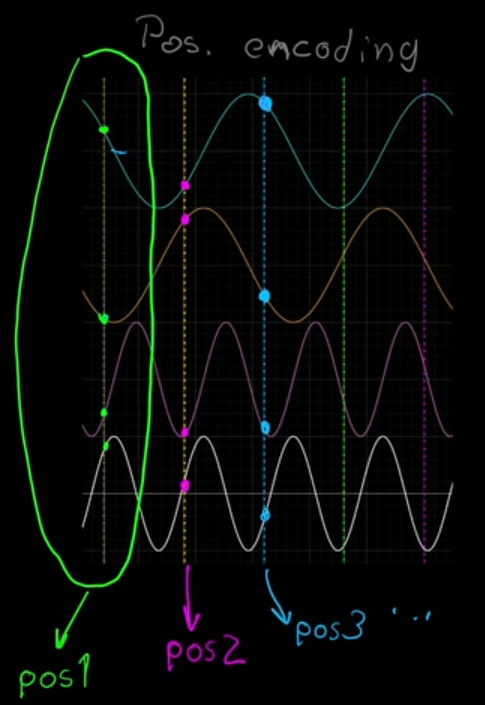

What is happening here is that to each word embedding we add the respective values of each function for its corresponding trace or dash. With this we make sure to preserve or 'encode' the position of the words in the original sentence. For the demo, we will assume the following values.

In [33]:
pos_1 = torch.asarray([0.3, -0.9, -0.6, 0.8])
pos_2 = torch.asarray([-0.6, 0.8, -0.9, 0.15])
pos_3 = torch.asarray([0.8, -0.5, -0.9, 0.5])
pos_4 = torch.asarray([-0.95, 0.2, -0.4, -0.9])
pos_5 = torch.asarray([0.95, 0.16, 0.2, -0.95])

# we add it to te embeddings
me+=pos_1
gusta+=pos_2
estudiar+=pos_3
inteligencia+=pos_4
artificial+=pos_5
print(me)

tensor([ 1.7455, -0.2399, -1.0670, -0.7417])


In [34]:
sentence = torch.cat([me, gusta, estudiar, inteligencia, artificial]).view(d_ff, -1).unsqueeze(0)
print(sentence, sentence.size())

tensor([[[ 1.7455, -0.2399, -1.0670, -0.7417],
         [-1.0961, -0.4019, -0.4606,  1.3690],
         [ 1.1993, -1.0065, -1.4196,  0.8725],
         [-1.4555, -0.5730,  1.1641, -0.0742],
         [ 0.3098,  2.3248, -0.2568, -1.1712]]]) torch.Size([1, 5, 4])


In [35]:
module = MultiHeadAttention(d_model, num_heads)
weighted_values, attention = module(sentence, sentence, sentence)

In [36]:
print(weighted_values, weighted_values.size())
print(attention, attention.size())

tensor([[[-0.1033,  0.6831,  0.1251, -0.5385],
         [-0.0828,  0.6085,  0.2094, -0.4515],
         [-0.0994,  0.6608,  0.1556, -0.5112],
         [-0.0847,  0.6110,  0.2026, -0.4563],
         [-0.0899,  0.6266,  0.1886, -0.4745]]], grad_fn=<ViewBackward0>) torch.Size([1, 5, 4])
tensor([[[[0.2187, 0.1942, 0.2240, 0.1980, 0.1650],
          [0.2607, 0.1570, 0.2259, 0.1570, 0.1994],
          [0.2332, 0.1835, 0.2307, 0.1871, 0.1655],
          [0.2436, 0.1674, 0.2179, 0.1672, 0.2039],
          [0.2430, 0.1665, 0.2156, 0.1658, 0.2091]],

         [[0.1639, 0.2215, 0.2051, 0.3233, 0.0862],
          [0.2189, 0.1612, 0.1783, 0.1387, 0.3030],
          [0.1956, 0.2009, 0.2048, 0.2720, 0.1266],
          [0.1986, 0.1863, 0.1867, 0.1483, 0.2801],
          [0.1859, 0.2145, 0.2008, 0.1900, 0.2089]]]],
       grad_fn=<SoftmaxBackward0>) torch.Size([1, 2, 5, 5])


### references

- Pepe Cantoral, Ph.D. (2024, June 20). Transformers - ¡Attention is all you need! Parte 2 [Video]. YouTube. https://www.youtube.com/watch?v=Nj5DVykeFhM
- Alammar, J. (n.d.). The illustrated transformer. https://jalammar.github.io/illustrated-transformer/
- Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, L., & Polosukhin, I. (2017, June 12). Attention is all you need. arXiv.org. https://arxiv.org/abs/1706.03762